# Assignment 5: The pair correlation function

The pair correlation function appears in the probability density of particle 1 being at position $\mathbf{r}_1$ with particle 2 being at position $\mathbf{r}_2$ at the same time, $\rho^{(2)}(\mathbf{r}_1, \mathbf{r}_1)$.

\begin{align}
    \rho^{(2)}(\mathbf{r}_1, \mathbf{r}_1) = \rho^{(1)}(\mathbf{r}_1) \rho^{(1)}(\mathbf{r}_2) g(\mathbf{r}_1, \mathbf{r}_2)
\end{align}

$g(\mathbf{r}_1, \mathbf{r}_2)$ is the pair correlation function. It is a measure for the correlation between the two single particle probability densities $\rho^{(1)}(\mathbf{r}_1)$ and $\rho^{(1)}(\mathbf{r}_2)$.
If the particles 1 and 2 are separated 

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from sargas import *
import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import glob
import re
from collections import namedtuple
from scipy.stats import gamma, maxwell, norm

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("Dark2")
sns.set_style("ticks")
sns.set_context("talk")

In [314]:
State = namedtuple("State", ["nparticles", "temperature", "density"])
SimulationParameters = namedtuple("SimulationParameters", ["dt", "nequilibration", "nproduction"], defaults=(0.01, 10_000, 100_000))
SamplingParameters = namedtuple("SamplingParameters", ["nsample", "ntrajectory", "filename"], defaults=(100, 500, "trajectory.xtc"))

def nvt_vv(state, rc, thermostat, thermostat_frequency=None, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    integrator = Integrator.velocity_verlet(simulation_parameters.dt)
    return nvt(state, rc, integrator, thermostat, thermostat_frequency, simulation_parameters, sampling_parameters)

def nvt(state, rc, integrator, thermostat=None, thermostat_frequency=None, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    potential = Potential.lennard_jones(1.0, 1.0, rc, True)
    configuration = Configuration.lattice(state.nparticles, state.density, initial_temperature=state.temperature)
    system = System(configuration, potential)
    propagator = MolecularDynamics(integrator, thermostat)
    simulation = Simulation.molecular_dynamics(system, propagator, thermostat_frequency=thermostat_frequency)

    # Equilibration
    eq_steps = simulation_parameters.nequilibration // 100
    for _ in tqdm.tqdm(range(100), desc="Equilibration"):
        simulation.run(eq_steps)
    
    # Add sampler
    props = Sampler.properties(sampling_parameters.nsample)
    trj = Sampler.trajectory(sampling_parameters.filename, sampling_parameters.ntrajectory)
    simulation.add_sampler(props)
    simulation.add_sampler(trj)
    # Production
    prod_steps = simulation_parameters.nproduction // 100
    for _ in tqdm.tqdm(range(100), desc="Production   "):
        simulation.run(prod_steps)
    
    data = pd.DataFrame(props.data)
    data["time"] = simulation_parameters.dt * data.index * sampling_parameters.nsample
    return data

## 

In [449]:
simulation_parameters = SimulationParameters(nequilibration=1000, nproduction=10_000)
state = State(2000, temperature=0.9, density=0.776)
rc = 3.0
thermostat = Thermostat.berendsen(state.temperature, simulation_parameters.dt, 1.25)
sim = nvt_vv(state, rc, thermostat, thermostat_frequency=1, simulation_parameters=simulation_parameters)

Production   : 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


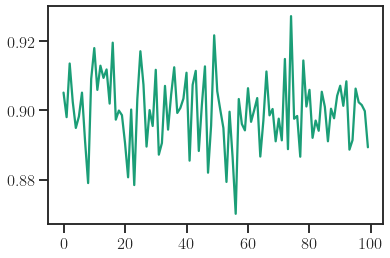

In [453]:
plt.plot(sim.temperature)

In [457]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

box_length = np.cbrt(state.nparticles / state.density)
u = mda.Universe("trajectory.xtc", guess_bonds=False)
#rdf = InterRDF(u.atoms, u.atoms, nbins=201, range=(1e-15, rc)) # box_length/2))
rdf = InterRDF(u.atoms, u.atoms, nbins=201, range=(1e-15, box_length/2))
rdf.run(0, 500);

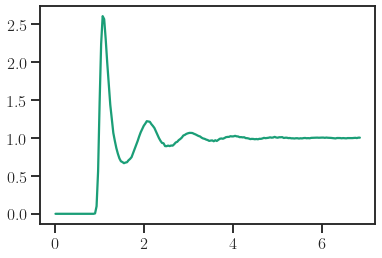

In [459]:
plt.plot(rdf.bins, rdf.rdf)

In [460]:
from scipy.integrate import simpson, cumulative_trapezoid, trapezoid

r = rdf.bins
g = rdf.rdf

integrant_u = g * r**2 * 4 * (r**(-12) - r**(-6))
integrant_p = g * r**2 * 24 * (2 * r**(-12) - r**(-6))

u_c = cumulative_trapezoid(integrant_u, r, initial=0)
p_c = cumulative_trapezoid(integrant_p, r, initial=0)

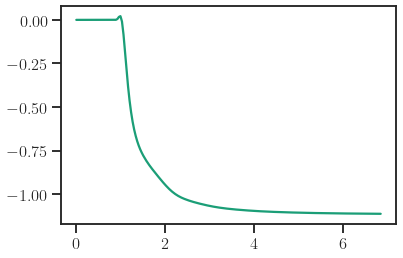

In [461]:
plt.plot(r, u_c)

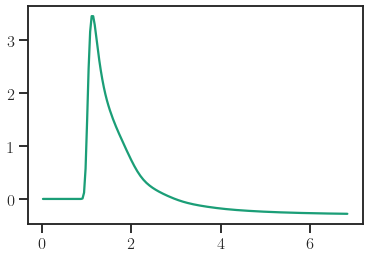

In [462]:
plt.plot(r, p_c)

In [499]:
energy_g = 3.0 / 2.0 * state.temperature + 2.0 * np.pi * state.density * u_c[-1] 
pressure_g = state.density * state.temperature + 2 / 3 * np.pi * state.density**2 * p_c[-1]

In [500]:
from pymbar.timeseries import integratedAutocorrelationTime

energy_iat = integratedAutocorrelationTime(sim.total_energy, fast=True)
pressure_iat = integratedAutocorrelationTime(sim.pressure, fast=True)
iat = max((1, int(2.0 * energy_iat), int(2.0 * pressure_iat)))
energy_ci = 1.96 * sim.total_energy[::iat].sem(ddof=1) / state.nparticles
pressure_ci = 1.96 * sim.pressure[::iat].sem(ddof=1)

energy_simulation = sim.total_energy.mean() / state.nparticles 
pressure_simulation = state.density * state.temperature + sim.pressure.mean()

In [501]:
print(f'U / N (simulation) = {energy_simulation:8.4f} ± {energy_ci:.4f}')
print(f'U / N (rdf)        = {energy_g:8.4f}')
print(f'p     (simulation) = {pressure_simulation:8.4f} ± {pressure_ci:.4f}')
print(f'p     (rdf)        = {pressure_g:8.4f}')

U / N (simulation) =  -4.1189 ± 0.0030
U / N (rdf)        =  -4.0786
p     (simulation) =   0.2338 ± 0.0442
p     (rdf)        =   0.3440


## Isothermal compressibility

- https://pubs.acs.org/doi/pdf/10.1021/jz301992u

The isothermal compressibility, $\kappa_T$ is defined as

\begin{align}
    \kappa_T = - \frac{1}{V} \left( \frac{\partial V}{\partial p} \right)_{T,N} 
\end{align}

The partial derivative in this equation can be estimated from multiple $N, V, T$ simulations at different densities.

An alternative route to compute this property from a *single* simulation
where $G^\infty_O$ is the so-called *Kirkwood-Buff integral*, which is defined as


\begin{align}
    \kappa_T =\frac{1 + \rho G^\infty_O}{\rho k_B T}
\end{align}

\begin{align}
    G^\infty_O = \int_0^\infty [g_O(r) - 1] 4 \pi r^2 \mathrm{d}r
\end{align}

Here, $g_O(r)$ denotes the pair correlation function in an $\mu, V, T$ ensemble ("o" stands for *open* ensemble, i.e. an ensemble with a fluctuating number of particles).


In [485]:
def gr_hat(g, r):
    result = []
    for i in range(len(g)):
        if i == 0:
            result.append(0)
            continue
        rr = r[:i]
        x = rr / (2.0 * rr[-1])
        w_x_dwdx = 4 * np.pi * rr**2 * (1 - x**3)
        integrant = (g[:i] - 1) * w_x_dwdx
        result.append(trapezoid(integrant, rr))
    return np.array(result)

def gr(g, r):
    result = []
    for i in range(len(g)):
        if i == 0:
            result.append(0)
            continue
        rr = r[:i]
        x = rr / (2.0 * rr[-1])
        w = 4 * np.pi * rr**2 * (1 - 3 / 2 * x + x**3 / 2)
        integrant = (g[:i] - 1) * w
        result.append(trapezoid(integrant, rr))
    return np.array(result)

def gr_tilde(g, r):
    integrant = (g - 1) * 4 * np.pi * r**2
    return cumulative_trapezoid(integrant, r, initial=0)

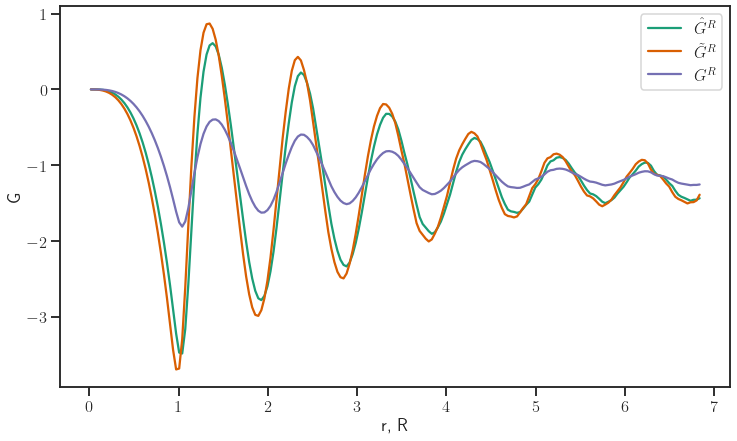

In [486]:
fig, ax = plt.subplots(figsize=(12, 7))
#plt.plot(r, g - 1, label='h(r)')
plt.plot(r, gr_hat(g, r), label=r'$\hat{G}^R$')
plt.plot(r, gr_tilde(g, r), label=r'$\tilde{G}^R$')
plt.plot(r, gr(g, r), label=r'$G^R$')
plt.ylabel('G')
plt.xlabel('r, R')
plt.legend(loc='best')

In [487]:
kappa_kb = 1 / (state.density * state.temperature) + gr(g, r)[-1] / state.temperature
kappa_kb

0.03756515430092833

## Equation of state

In [473]:
h = 0.05
densities = state.density + np.array([-2*h, -h, h, 2*h, 0])
dfs = {}

for density in densities:
    s = State(500, temperature=state.temperature, density=density)
    sampling_parameters = SamplingParameters(nsample=100, ntrajectory=1000000, filename=f'traj_{density}.xtc')
    simulation_parameters = SimulationParameters(dt=0.01, nequilibration=10_000, nproduction=20_000)
    thermostat = Thermostat.berendsen(state.temperature, simulation_parameters.dt, 1.25)
    sim_i = nvt_vv(s, rc, thermostat, thermostat_frequency=1, simulation_parameters=simulation_parameters, sampling_parameters=sampling_parameters)
    dfs.update({density: sim_i})

Production   : 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


\begin{align}
    \kappa_T = - \frac{1}{V} \left( \frac{\partial V}{\partial p} \right)_{T,N} = \frac{1 + \rho G^\infty_O}{\rho k_B T}
\end{align}

where $G^\infty_O$ is the so-called *Kirkwood-Buff integral*, which is defined as

\begin{align}
    G^\infty_O = \int_0^\infty [g_O(r) - 1] 4 \pi r^2 \mathrm{d}r
\end{align}

Here, $g_O(r)$ denotes the pair correlation function in an $\mu, V, T$ ensemble ("o" stands for *open* ensemble, i.e. an ensemble with a fluctuating number of particles).


In [502]:
plt.plot(0.66 * 0.9 + dfs[0.66].pressure)

KeyError: 0.66

In [474]:
dfff = pd.DataFrame([{'density': k, 'pressure': density * state.temperature + v.pressure.mean()} for k, v in dfs.items()])
dfff.set_index('density', inplace=True)
dfff

,pressure
density,
0.676,-0.296324
0.726,-0.131604
0.826,0.901179
0.876,1.912291
0.776,0.244993


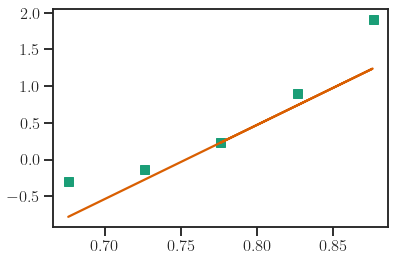

In [482]:
plt.plot(dfff.index, dfff.pressure, 's')
plt.plot(dfff.index, dp_drho * dfff.index - 7.6)

In [428]:
dfff.iloc[0]

pressure   -0.656069
Name: 0.66, dtype: float64

In [477]:
dp_drho = (-dfff.iloc[3].pressure + 8.0 * dfff.iloc[2].pressure - 8.0 * dfff.iloc[1].pressure + dfff.iloc[0].pressure) / (12 * h)
dp_drho

10.08941590518488

In [488]:
kappa__ = 1 / dfff.index[-1] / dp_drho
kappa__

0.12772392435048688

In [492]:
0.8 * 0.776 + sim.pressure.mean(), dfff.iloc[-1].pressure

(0.15622781747884362, 0.24499323495307362)

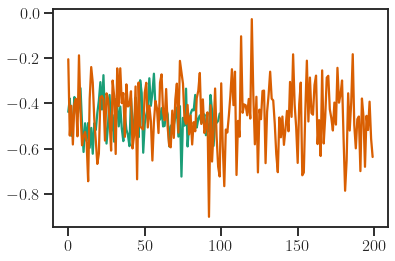

In [498]:
plt.plot(sim.pressure)
plt.plot(dfs[0.776].pressure)

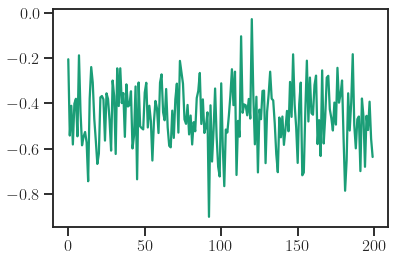

In [497]:
plt.plot(dfs[0.776].pressure)